In [1]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Import raw files

df_2022 = pd.read_csv(
    filepath_or_buffer = 'processed files/phoneUsage_2022_clean.csv',
    parse_dates = [0]
)


df_2023 = pd.read_csv(
    filepath_or_buffer = 'processed files/phoneUsage_2023_clean.csv',
    parse_dates = [0]
)

In [3]:
# Convert tables from wide to long format

df_2022 = pd.melt(
    frame = df_2022,
    id_vars = 'date',
    var_name = 'apps',
    value_name = 'duration'
)

df_2023 = pd.melt(
    frame = df_2023,
    id_vars = 'date',
    var_name = 'apps',
    value_name = 'duration'
)

In [4]:
# Merge 2022 and 2023 raw data into a single dataframe

df_long = pd.merge(
    left = df_2022,
    right = df_2023,
    on = ['apps', 'duration', 'date'],
    how = 'outer'
)

In [5]:
# Convert duration column to Pandas duration data type

df_long['duration'] = pd.to_timedelta(
    arg = df_long['duration']
)

In [6]:
# Import category file

df_cat = pd.read_csv(
    filepath_or_buffer = 'processed files/phoneUsage_categories.csv'
)

In [7]:
# Rename column app to apps for merging

df_cat = df_cat.rename(
    columns = {'app': 'apps'}
)

In [8]:
# Add category and primary key on main dataframe

df_long = pd.merge(
    left = df_long,
    right = df_cat,
    on = 'apps',
    how = 'left'
)

In [9]:
# Reassign index and rearrange columns

df_long.index = df_long['date']
df_long.index.name = None

df_test = df_long.drop(
    columns = 'date'
)

df_long = df_long[['app_ID', 'apps', 'category', 'duration']]

In [ ]:
'''
Data limitations: 2023-01-01 to 2023-07-31

Question: Do I really need a new phone?
Revised question: Was buying a new monitor a better move instead of buying a new phone?
Supporting information:
    Answer the following:
        If productivity, work, finances and communications are essential, do I spend more time on them compare to just browsing, watching and scrolling through social media apps?
        At what point did I had a significant or noticeable decline in usage? What apps were not present during the dip?
        Did going to the gym helped with the decline? Assuming it started on 2023-06-01
        During what day of the week am I spending most time on using phone? Give the top 5 apps mostly used during that day.
        Will I need a new phone on 2024 assuming the total monthly time spent is linear?
    
    Visualize the following:
        Compare the categories to one another
        Visualize the month on month trend of my overall phone usage
        Visualize the month on month trend of my online shopping behavior
        Visualize the month on month trend of my browsing behavior

    Bonus:
        Was there an increase of time upskilling after buying a new monitor? Monitor was first used on 2023-10-14
        Compare time spent upskilling vs streaming plus browsing
'''

- If productivity, work, finances and communications are essential, do I spend more time on them compare to just browsing, watching and scrolling through social media apps?

In [10]:
# Get the data for 2023 only

df_2023 = df_long['2023-01-01':]

In [11]:
# Category list
df_2023['category'].unique()

array(['Productivity', 'Work-related', 'Finances', 'Internet browsing',
       'Miscellaneous', 'Streaming', 'Communication', 'Phone maintenance',
       'Online shopping', 'Socials', 'Music'], dtype=object)

In [12]:
# Isolate essential apps

essential = df_2023.loc[
    (df_2023['category'] == 'Productivity') |
    (df_2023['category'] == 'Work-related') |
    (df_2023['category'] == 'Finances') |
    (df_2023['category'] == 'Communication')
]

In [ ]:
essentials = essential[['category', 'duration']]

essentials['category'] = 'Essentials'

In [14]:
# Isolate pastime apps

pastime = df_2023.loc[
    (df_2023['category'] == 'Streaming') |
    (df_2023['category'] == 'Internet browsing') |
    (df_2023['category'] == 'Socials')
]

In [ ]:
pastimes = pastime[['category', 'duration']]
pastimes['category'] = 'Pastime'

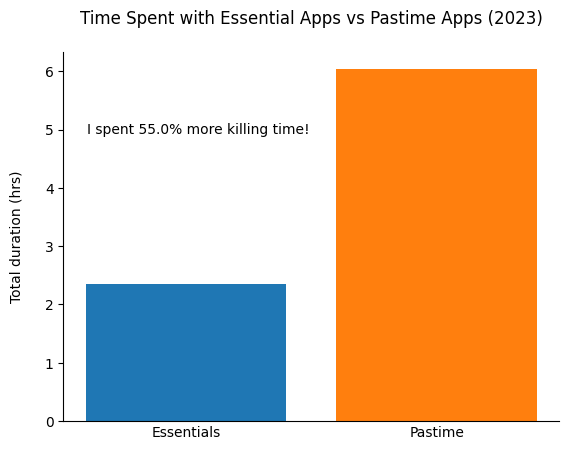

In [16]:
# Plot total hours spent between essentials and pastime

plt.bar(
    x = essentials['category'],
    height = essentials['duration'].dt.total_seconds() / 3600
)

plt.bar(
    x = pastimes['category'],
    height = pastimes['duration'].dt.total_seconds() / 3600
)


# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Remove x-axis tick marks
plt.tick_params(
    axis = 'x',
    length = 0
)


# Add title
plt.title(
    label = 'Time Spent with Essential Apps vs Pastime Apps (2023)',
    pad = 20
)


# Add context to y-axis
plt.ylabel(
    ylabel = 'Total duration (hrs)',
    labelpad = 15
)


# Get the percentage difference between pastime to essentials
app_diff = 1 - (essentials['duration'].sum() / pastimes['duration'].sum())
app_diff = np.round(
    a = (1 - app_diff) * 100,
    decimals = 0
)

plt.text(
    x = 0.05,
    y = 5,
    s = f"I spent {app_diff}% more killing time!",
    horizontalalignment = 'center',
    verticalalignment = 'center',
    wrap = True
)

plt.show()

- At what point did I had a significant or noticeable decline in usage? What apps were not present during the dip?

In [19]:
# First check trend on a day to day basis

dod_duration = pd.pivot_table(
    data = df_2023,
    values = 'duration',
    index = df_2023.index,
    aggfunc = 'sum'
)

dod_duration

,duration
2023-01-01,0 days 03:14:44
2023-01-02,0 days 01:36:08
2023-01-03,0 days 03:06:17
2023-01-04,0 days 03:32:01
2023-01-05,0 days 03:25:36
...,...
2023-07-27,0 days 02:26:05
2023-07-28,0 days 02:20:09
2023-07-29,0 days 01:24:42
2023-07-30,0 days 00:56:06


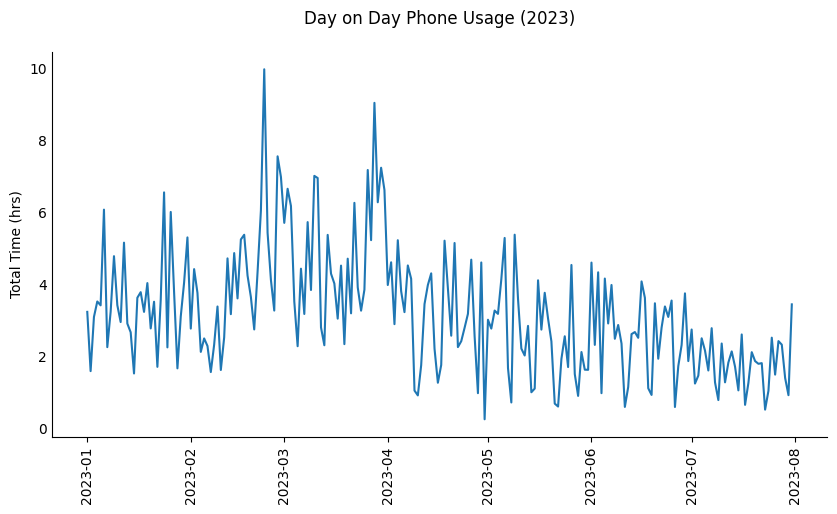

In [20]:
# Plot day on day data

plt.figure(
    figsize = (10, 5),
    dpi = 100
)

plt.plot(
    dod_duration.index,
    dod_duration['duration'].dt.total_seconds() / 3600,
)

plt.title(
    label = 'Day on Day Phone Usage (2023)',
    pad = 20
)

plt.ylabel(ylabel = 'Total Time (hrs)')
plt.xticks(rotation = 90)
plt.tick_params(
    axis = 'y',
    length = 0
)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [21]:
# Check trend on a month on month basis

mom_duration = pd.pivot_table(
    data = df_2023,
    values = 'duration',
    index = df_2023.index.month,
    aggfunc = 'sum'
)

mom_duration.index.name = None

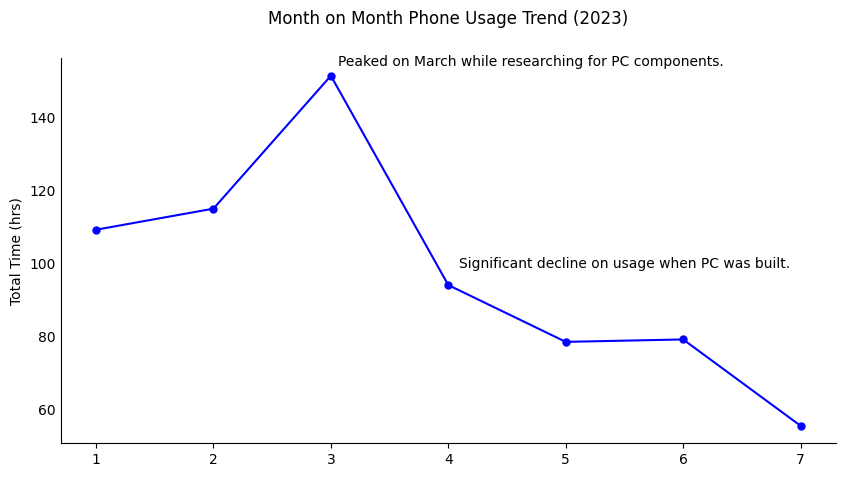

In [22]:
# Plot month on month data
import calendar


plt.figure(
    figsize = (10, 5),
    dpi = 100
)

plt.plot(
    mom_duration.index,
    mom_duration['duration'].dt.total_seconds() / 3600,
    color = 'blue',
    marker = 'o',
    markersize = 5
)

plt.title(
    label = 'Month on Month Phone Usage Trend (2023)',
    pad = 25
)

plt.ylabel(ylabel = 'Total Time (hrs)')
plt.tick_params(
    axis = 'y',
    length = 0
)

plt.text(
    x = 5.5,
    y = 100,
    s = 'Significant decline on usage when PC was built.',
    horizontalalignment = 'center',
    verticalalignment = 'center',
    wrap = True
)

plt.text(
    x = 4.7,
    y = 155,
    s = 'Peaked on March while researching for PC components.',
    horizontalalignment = 'center',
    verticalalignment = 'center',
    wrap = True
)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()